# Plots graphs for read, write given .csv's from run_daos framework

### Inputs: 
#### Filenames of .csv files
### Outputs: 
#### Inline plots for read, write
#### PNG files of graphs for read, write

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

### USER INPUT: Enter .csv's filenames here

In [2]:
files = [
         'pune_setups/testout_DFS_Node-3.csv',
         'pune_setups/testout_POSIX_Node-3.csv',
         'pune_setups/testout_MPIIO_Node-3.csv',
        ]

In [3]:
# order to follow when plotting graphs...
my_order = {'4K': 1, '1M': 2, '4M': 3, '64M': 4, '128M': 5}

# supported operations
operations = ['read', 'write']

In [4]:
num_files = len(files)

dframes = [pd.read_csv(file) for file in files]

def get_API_from_csv_fname(csv_fname):
    if 'POSIX' in csv_fname:
        return 'POSIX'
    elif 'DFS' in csv_fname:
        return 'DFS'
    elif 'MPIIO' in csv_fname:
        return 'MPIIO'
    else:
        print('Error! Invalid API detected!')
        raise SystemExit('Cannot continue!')
    
def get_num_nodes_from_csv_fname(csv_fname):
    pattern = '.*Node-(?P<num_nodes>\d).*'
    result = re.match(pattern, csv_fname)
    
    if result:
        return result.group('num_nodes')
        
    else:
        print('Couldn\'t find number of nodes from {}'.format(csv_fname))
        raise SystemExit('Cannot continue!')

# get xfersizes from all dframes / files
# then get the minimum common set for plotting
# finally, return it as a list
def get_xfersizes_from_dframes(dframes):
    xfersizes = []
    for dframe in dframes:
        df = dframe.dropna()
        xfersizes.append(set(df['xfersize'].unique()))
    return list(set.intersection(*xfersizes))
    
APIs = [get_API_from_csv_fname(file) for file in files]
Num_nodes = [get_num_nodes_from_csv_fname(file) for file in files]
xfersizes = get_xfersizes_from_dframes(dframes)

# re-order xfersizes to follow the desired order for plotting
xfersizes.sort(key = lambda x: my_order[x])

print('Got {} .csv files with following specs:'.format(num_files))
print('\tAPIs: {}'.format(APIs))
print('\tNum_nodes: {}'.format(Num_nodes))
print('\txfersizes: {}'.format(xfersizes))

Got 3 .csv files with following specs:
	APIs: ['DFS', 'POSIX', 'MPIIO']
	Num_nodes: ['3', '3', '3']
	xfersizes: ['4K', '1M', '4M', '64M', '128M']


In [5]:
# x-axis - get max clients across all .csv files
num_clients = max(df['clients'].max() for df in dframes)

# y-axis - get the max across all .csv files
max_read = max(df['read'].max() for df in dframes)
max_write = max(df['write'].max() for df in dframes)

dfs_to_plot = [list() for file in files]

# create composite list of DataFrames
for i in range(num_files):
    for xfersize in xfersizes:
        dfs_to_plot[i].append(dframes[i].iloc[dframes[i].groupby('xfersize').groups[xfersize]].reset_index())

In [6]:
# plotting function
def create_io_plot(oper='read'):
    fig, axs = plt.subplots(1, len(dfs_to_plot[0]), sharex=True, sharey=True)
    big_label = "{} performance across xfersizes".format(oper.capitalize())
    
    fig.suptitle(big_label)
    fig.set_figwidth(10)
    
    for ax in axs.flat:
        ax.set(xlabel='# of clients/node')
        ax.set(ylabel='MB/sec')
        ax.autoscale(enable=True)
        ax.set_aspect('auto')
        ax.grid()
        ax.label_outer()   
    
    for i in range(len(dfs_to_plot[0])):
        plot_hndls = []
        for j in range(num_files):
            plot_label = '{}/{}N'.format(APIs[j], Num_nodes[j])
            p_hndl, = axs[i].plot(dfs_to_plot[j][i][oper], label=plot_label)
            plot_hndls.append(p_hndl)
        axs[i].set_title('xfersize={}'.format(xfersizes[i]))     
        axs[i].legend(handles=plot_hndls, shadow=True)
    
    plt.tight_layout()
    
    # save .png files as well for the report!
    fname_str = ''
    for i in range(num_files):
        fname_str += '_{}-{}N'.format(APIs[i], Num_nodes[i])
    png_fname = '{}'.format(oper.capitalize()) + fname_str + '.png'
    print('Wrote {}'.format(png_fname))
    plt.savefig(png_fname)

Wrote Read_DFS-3N_POSIX-3N_MPIIO-3N.png
Wrote Write_DFS-3N_POSIX-3N_MPIIO-3N.png


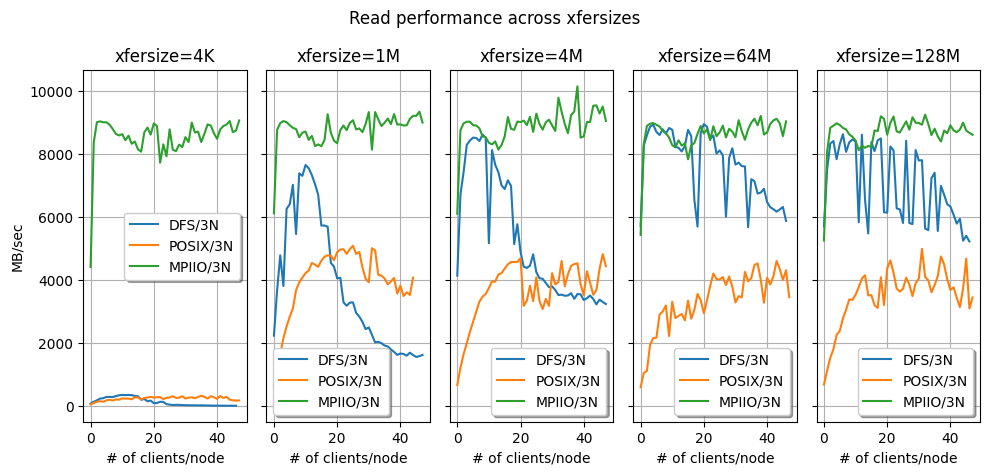

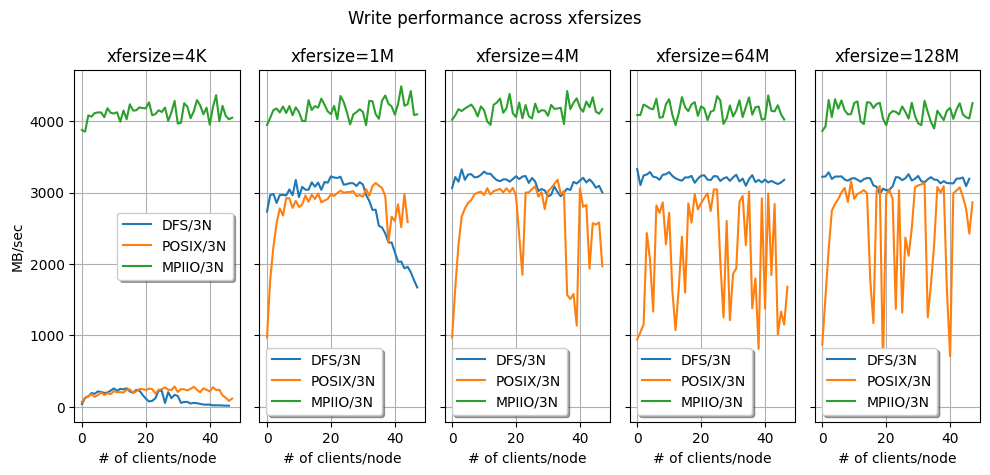

In [7]:
create_io_plot('read')
create_io_plot('write')